In [31]:
pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [32]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import MulticlassJaccardIndex, MulticlassAccuracy

In [33]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image'].float()
            mask = augmented['mask'].long()

        return image, mask.long()

In [34]:
def get_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(p=0.3),      
        A.GridDistortion(p=0.3),       
        # A.Normalize(mean=(0.485, 0.456, 0.406),
        #             std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


train_dataset = SegmentationDataset(
    image_dir='/kaggle/input/spinach-leaf-area/spinach/images/train',
    mask_dir='/kaggle/input/spinach-leaf-area/spinach/masks/train',
    transform=get_transforms()
)

val_dataset = SegmentationDataset(
    image_dir='/kaggle/input/spinach-leaf-area/spinach/images/val',
    mask_dir='/kaggle/input/spinach-leaf-area/spinach/masks/val',
    transform=get_transforms()
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [35]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3
)
model = nn.DataParallel(model)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#############################################################
class_weights = torch.tensor([0.1, 1.0, 5.0]).to(device)

dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
# focal = smp.losses.FocalLoss(mode='multiclass', ignore_index=0)
ce = nn.CrossEntropyLoss(weight=class_weights)

def combined_loss(pred, target):
    return 0.5 * dice(pred, target) + 0.5 * ce(pred, target)

#############################################################

criterion = combined_loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#############################################################


def train_model(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    for x, y in tqdm(loader, desc='\tTraining: '):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_model(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc='\tEvaluating: '):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

iou_metric = MulticlassJaccardIndex(num_classes=3).to(device)
acc_metric = MulticlassAccuracy(num_classes=3, average='weighted').to(device)

def evaluate_metrics(model, loader):
    model.eval()
    iou_metric.reset()
    acc_metric.reset()
    with torch.no_grad():
        for x, y in tqdm(loader, desc='\tEval metrics'):
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = torch.argmax(out, dim=1)
            iou_metric.update(pred, y)
            acc_metric.update(pred, y)
    iou = iou_metric.compute().cpu().numpy()
    acc = acc_metric.compute().item()
    return iou, acc

#############################################################

train_losses, train_ious, train_accs = [], [], []
val_losses, val_ious, val_accs = [], [], []
for epoch in range(1, 21):
    print(f"[Epoch {epoch}]")
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_loss = eval_model(model, val_loader, criterion)
    train_iou, train_acc = evaluate_metrics(model, train_loader)
    val_iou, val_acc = evaluate_metrics(model, val_loader)
    
    train_losses.append(train_loss)
    train_ious.append(train_iou)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_ious.append(val_iou)
    val_accs.append(val_acc)
    
    print(f"\t-> Train Loss: {train_loss:.4f}, mIoU: {train_iou.mean():.4f}, Acc: {train_acc:.4f}")
    print(f"\t-> Val Loss: {val_loss:.4f}, mIoU: {val_iou.mean():.4f}, Acc: {val_acc:.4f}")
    print('#################################################################')

[Epoch 1]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


	-> Train Loss: 0.4082, mIoU: 0.6193, Acc: 0.9186
	-> Val Loss: 0.2838, mIoU: 0.6284, Acc: 0.9253
#################################################################
[Epoch 2]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


	-> Train Loss: 0.2642, mIoU: 0.7310, Acc: 0.9542
	-> Val Loss: 0.4069, mIoU: 0.7324, Acc: 0.9538
#################################################################
[Epoch 3]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


	-> Train Loss: 0.1986, mIoU: 0.7703, Acc: 0.9499
	-> Val Loss: 0.4866, mIoU: 0.7656, Acc: 0.9471
#################################################################
[Epoch 4]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


	-> Train Loss: 0.1352, mIoU: 0.8965, Acc: 0.9769
	-> Val Loss: 0.1262, mIoU: 0.8917, Acc: 0.9793
#################################################################
[Epoch 5]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


	-> Train Loss: 0.0849, mIoU: 0.8892, Acc: 0.9723
	-> Val Loss: 0.0986, mIoU: 0.8980, Acc: 0.9721
#################################################################
[Epoch 6]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


	-> Train Loss: 0.0689, mIoU: 0.8831, Acc: 0.9690
	-> Val Loss: 0.0885, mIoU: 0.8994, Acc: 0.9738
#################################################################
[Epoch 7]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


	-> Train Loss: 0.0610, mIoU: 0.8576, Acc: 0.9635
	-> Val Loss: 0.0711, mIoU: 0.9043, Acc: 0.9755
#################################################################
[Epoch 8]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


	-> Train Loss: 0.0595, mIoU: 0.9135, Acc: 0.9742
	-> Val Loss: 0.0609, mIoU: 0.9163, Acc: 0.9777
#################################################################
[Epoch 9]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


	-> Train Loss: 0.0468, mIoU: 0.9276, Acc: 0.9776
	-> Val Loss: 0.0510, mIoU: 0.9249, Acc: 0.9799
#################################################################
[Epoch 10]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


	-> Train Loss: 0.0440, mIoU: 0.9273, Acc: 0.9770
	-> Val Loss: 0.0482, mIoU: 0.9208, Acc: 0.9794
#################################################################
[Epoch 11]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


	-> Train Loss: 0.0513, mIoU: 0.8281, Acc: 0.9642
	-> Val Loss: 0.1670, mIoU: 0.8759, Acc: 0.9744
#################################################################
[Epoch 12]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


	-> Train Loss: 0.0563, mIoU: 0.9275, Acc: 0.9767
	-> Val Loss: 0.0416, mIoU: 0.9307, Acc: 0.9786
#################################################################
[Epoch 13]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


	-> Train Loss: 0.0449, mIoU: 0.9034, Acc: 0.9779
	-> Val Loss: 0.0746, mIoU: 0.8920, Acc: 0.9801
#################################################################
[Epoch 14]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


	-> Train Loss: 0.0408, mIoU: 0.9256, Acc: 0.9747
	-> Val Loss: 0.0400, mIoU: 0.9267, Acc: 0.9769
#################################################################
[Epoch 15]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


	-> Train Loss: 0.0360, mIoU: 0.9329, Acc: 0.9790
	-> Val Loss: 0.0441, mIoU: 0.9229, Acc: 0.9803
#################################################################
[Epoch 16]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


	-> Train Loss: 0.0406, mIoU: 0.9255, Acc: 0.9755
	-> Val Loss: 0.0409, mIoU: 0.9257, Acc: 0.9777
#################################################################
[Epoch 17]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


	-> Train Loss: 0.0408, mIoU: 0.9245, Acc: 0.9753
	-> Val Loss: 0.0419, mIoU: 0.9227, Acc: 0.9766
#################################################################
[Epoch 18]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


	-> Train Loss: 0.0375, mIoU: 0.8705, Acc: 0.9737
	-> Val Loss: 0.0578, mIoU: 0.9057, Acc: 0.9792
#################################################################
[Epoch 19]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


	-> Train Loss: 0.0351, mIoU: 0.8249, Acc: 0.9650
	-> Val Loss: 0.1453, mIoU: 0.8342, Acc: 0.9720
#################################################################
[Epoch 20]


	Eval metrics: 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

	-> Train Loss: 0.0364, mIoU: 0.9278, Acc: 0.9764
	-> Val Loss: 0.0393, mIoU: 0.9270, Acc: 0.9770
#################################################################


In [37]:
torch.save(model.state_dict(), 'best_model.pth')

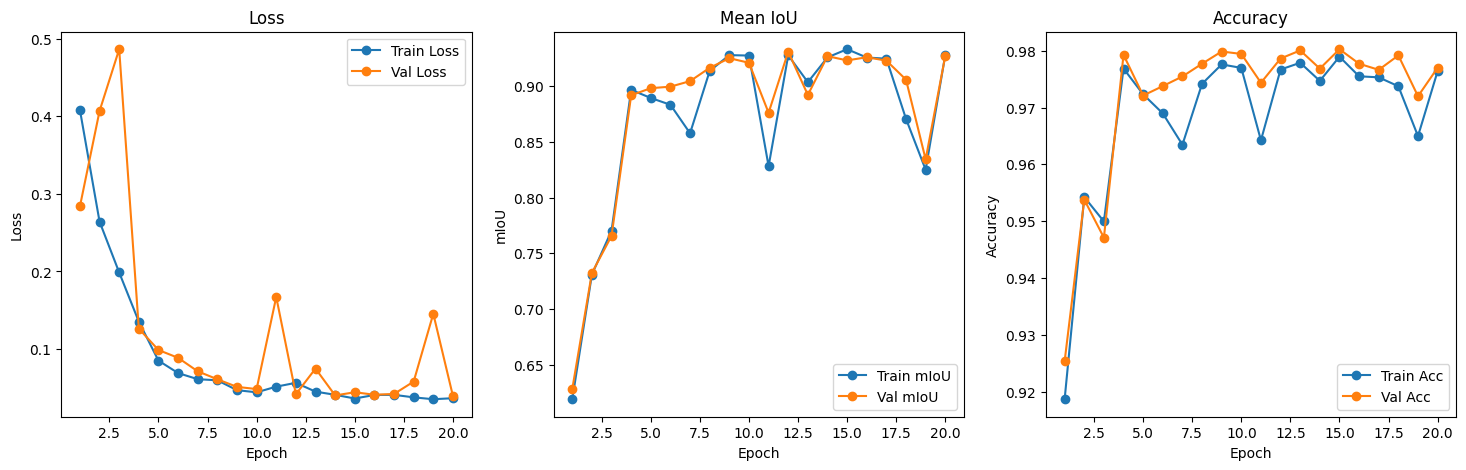

In [41]:
def visualize_train_process(train_losses, train_ious, train_accs, val_losses, val_ious, val_accs):
    """
    Plots the training and validation loss, mIoU, and accuracy over epochs.
    """
    epochs = list(range(1, len(train_losses) + 1))
    # Compute mean IoU per epoch
    train_iou_means = [iou.mean() for iou in train_ious]
    val_iou_means   = [iou.mean() for iou in val_ious]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss plot
    axes[0].plot(epochs, train_losses, '-o', label='Train Loss')
    axes[0].plot(epochs, val_losses,   '-o', label='Val Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # mIoU plot
    axes[1].plot(epochs, train_iou_means, '-o', label='Train mIoU')
    axes[1].plot(epochs, val_iou_means,   '-o', label='Val mIoU')
    axes[1].set_title('Mean IoU')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('mIoU')
    axes[1].legend()

    # Accuracy plot
    axes[2].plot(epochs, train_accs, '-o', label='Train Acc')
    axes[2].plot(epochs, val_accs,   '-o', label='Val Acc')
    axes[2].set_title('Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()

visualize_train_process(train_losses, train_ious, train_accs, val_losses, val_ious, val_accs)

(640, 640, 3)


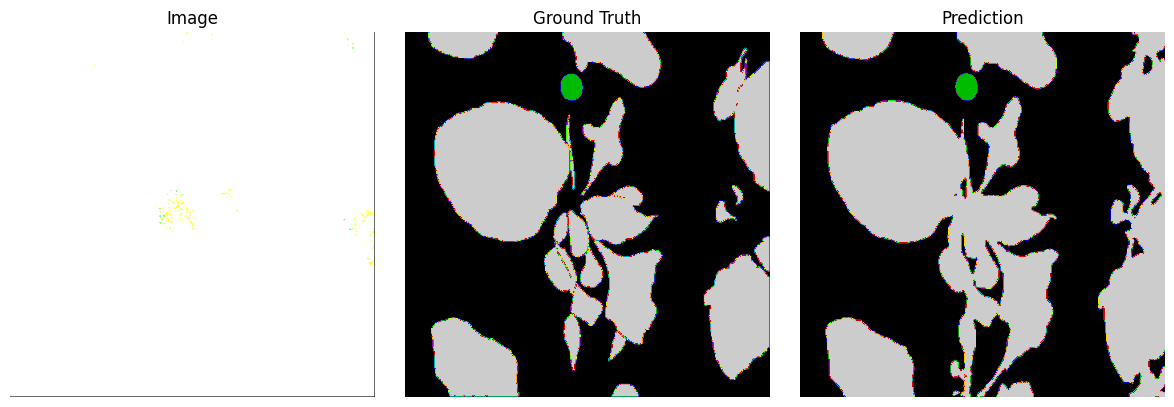

In [39]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    image, true_mask = dataset[idx]
    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()

    image_np = image.permute(1, 2, 0).numpy()
    true_mask = true_mask.numpy()
    print(image_np.shape)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[1].imshow(true_mask, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, train_dataset, idx=1)

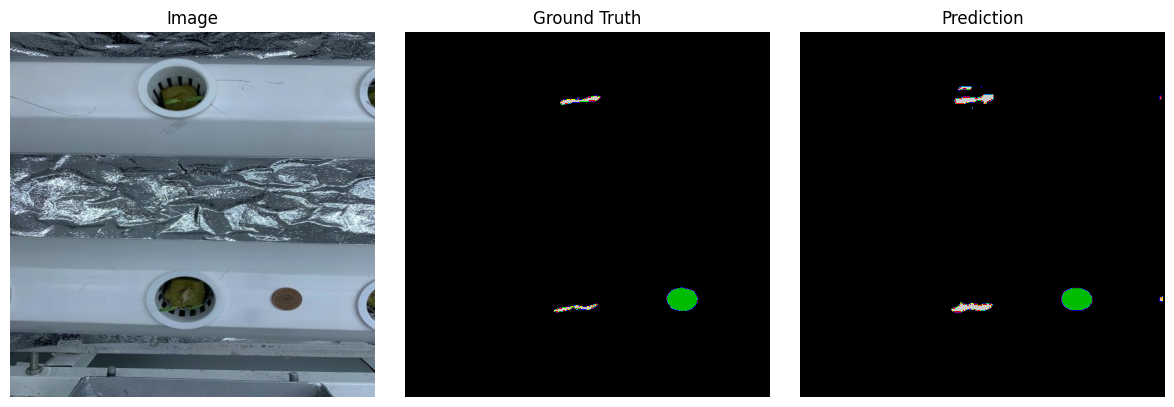

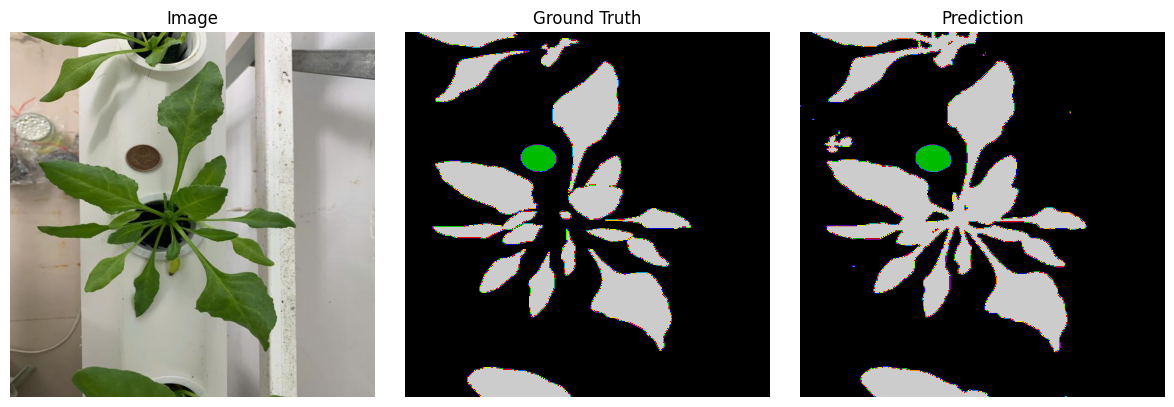

In [40]:
def visualize_prediction(model, dataset, idx=0):
    image = cv2.imread(dataset.image_paths[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    true_mask = cv2.imread(dataset.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

    image_in = torch.Tensor(image).float().permute(2, 0, 1)
    model.eval()
    with torch.no_grad():
        pred_mask = model(image_in.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred_mask.squeeze(), dim=0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[1].imshow(true_mask, cmap='nipy_spectral')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask, cmap='nipy_spectral')
    axs[2].set_title("Prediction")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_prediction(model, val_dataset, idx=11)
visualize_prediction(model, val_dataset, idx=20)